In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, label_binarize, normalize
from sklearn.base import BaseEstimator, TransformerMixin

from pymongo import MongoClient
client = MongoClient() # Creates a client that uses the default port on localhost.
database = client.medical_notes_kaggle # Connect to medical_notes_kaggle database

In [25]:
# Classes

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [2]:
def compute_multiclass_ROC(y_test, y_score):
    """
    Takes "y_test" and "y_score" as inputs and returns the fpr, tpr, and roc_auc scores dictionary.
    
    Taken from scikit-learn's plot_roc tutorial. See below:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    
    fpr, tpr, thresholds, roc_auc = dict(), dict(), dict(), dict()
    
    # Compute micro-average ROC curve and ROC AUC
    for i in range(5):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test[:,i], y_score[:,i])

    # Collect results
    fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)])) # Aggregate all false positive rates

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5 # Average it

    # Collect Results
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

# Import Data

In [50]:
# import labeled data
mongodb_query = database.train.find({})
train_tuple = list(mongodb_query)

# Store data in a dataframe
train_df = pd.DataFrame(columns=['index_', 'note_text', 'section_headers', 'clinical_domain']) # Create empty dataframe
keys_to_exclude = set(('_id', 'index_', 'clinical_domain'))

for i in range(len(train_tuple)):
    index_int = int(str({v for k,v in train_tuple[i].items() if k in 'index_'})[2:-2])
    note_text_str = str({v for k,v in train_tuple[i].items() if k not in keys_to_exclude})[1:-1]
    section_headers_str = str({k for k,v in train_tuple[i].items() if k not in keys_to_exclude})[1:-1]
    clinical_domain_str = str({v for k,v in train_tuple[i].items() if k in 'clinical_domain'})[2:-2]

    train_df = train_df.append(
        {'index_': index_int,
         'clinical_domain': clinical_domain_str,
         'note_text': note_text_str,
         'section_headers': section_headers_str}, ignore_index=True)
    
train_df = train_df.sort_values('index_').reset_index(drop=True) # Sort values to ensure data is in the same order

# Drop missing values
train_df.section_headers = train_df.section_headers.replace('et(', np.nan)
train_df.note_text = train_df.note_text.replace('et(', np.nan)
train_df = train_df.dropna().reset_index(drop=True)

train_df['text_length'] = train_df.note_text.apply(len) # Add text_length column
train_df['section_headers_count'] = train_df.section_headers.apply(lambda x: x.count(',') +1) # Count section headers

In [51]:
train_df.head() # View data

,index_,note_text,section_headers,clinical_domain,text_length,section_headers_count
0,1001,"'Ortho-Novum 7-7-7 (started 2/3/96), and ASA (...","'FHX', 'MEDS', 'SHX', 'EXAM', 'PMH', 'COURSE',...",Neurology,5433,8
1,1002,"'After a successful anesthetic, the patient wa...","'OPERATION', 'ANESTHESIA', 'PREOPERATIVE DIAGN...",Orthopedic,1432,5
2,1003,"'Round French 10 JP drain.', '1000 mL.', 'This...","'URINE OUTPUT', 'DESCRIPTION OF PROCEDURE', 'D...",Orthopedic,6452,13
3,1004,'This is a 69-year-old male with pain in the s...,"'CLINICAL', 'FINDINGS', 'EXAM', 'IMPRESSION'",Radiology,2765,4
4,1005,"'1. Today, we did review remaining treatment ...","'PAST MEDICAL HISTORY, FAMILY HISTORY, SOCIAL ...",Orthopedic,3119,8


In [58]:
# Apply one-hot-encoding to each of the categories
section_headers_df = pd.get_dummies(train_df.section_headers.apply(lambda x: x.split(',')).apply(pd.Series).stack()).sum(level=0)

In [60]:
section_headers_df.head() # View data

,"""PATIENT'S GOAL""",'1. RIGHT BICEPS','10. ANTERIOR TIBIALIS','11. RIGHT GASTROCNEMIUS','12. LEFT GASTROCNEMIUS','13. LEFT VASTUS MEDIALIS','2-D M-MODE','2. RIGHT TRICEPS','3. EXTENSOR DIGITORUM','4. FIRST DORSAL INTEROSSEOUS',...,'SYMPTOM','TECHNIQUE AND FINDINGS','TEST','TESTICULAR ULTRASOUND','THORACIC SPINE','TIME SEEN','TITLE OF PROCEDURE','TOTAL FLUID','URINE OUTPUT','text_0'
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Add one-hot-encoded section_headers back into the main dataframe
train_df = train_df.merge(section_headers_df, left_index=True, right_index=True)
train_df

,index_,note_text,section_headers,clinical_domain,text_length,section_headers_count,"""PATIENT'S GOAL""",'1. RIGHT BICEPS','10. ANTERIOR TIBIALIS','11. RIGHT GASTROCNEMIUS',...,'SYMPTOM','TECHNIQUE AND FINDINGS','TEST','TESTICULAR ULTRASOUND','THORACIC SPINE','TIME SEEN','TITLE OF PROCEDURE','TOTAL FLUID','URINE OUTPUT','text_0'
0,1001,"'Ortho-Novum 7-7-7 (started 2/3/96), and ASA (...","'FHX', 'MEDS', 'SHX', 'EXAM', 'PMH', 'COURSE',...",Neurology,5433,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1002,"'After a successful anesthetic, the patient wa...","'OPERATION', 'ANESTHESIA', 'PREOPERATIVE DIAGN...",Orthopedic,1432,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,"'Round French 10 JP drain.', '1000 mL.', 'This...","'URINE OUTPUT', 'DESCRIPTION OF PROCEDURE', 'D...",Orthopedic,6452,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1004,'This is a 69-year-old male with pain in the s...,"'CLINICAL', 'FINDINGS', 'EXAM', 'IMPRESSION'",Radiology,2765,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1005,"'1. Today, we did review remaining treatment ...","'PAST MEDICAL HISTORY, FAMILY HISTORY, SOCIAL ...",Orthopedic,3119,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1006,"'Hypertension, hypothyroidism, degenerative jo...","'CHIEF COMPLAINT', 'PHYSICAL EXAMINATION', 'ME...",Orthopedic,6717,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1007,"'I will have the patient follow up with me, wi...","'PROCEDURE', 'INDICATIONS', 'PLAN', 'PROCEDURE...",Gastroenterology,3040,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1008,"""1) Obesity. 2) VBG, 1990. 3) A-Fib. 4) HTN....","'FHX', 'MEDS', 'SHX', 'EXAM', 'PMH', 'COURSE',...",Radiology,1645,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1009,"'None.', 'Fertile male with completed family.'...","'PROCEDURE NOTE', 'PROCEDURE', 'PREOPERATIVE D...",Urology,1985,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1010,'1. Lumbar muscle strain. 2. Chronic back pa...,"'ASSESSMENT', 'PHYSICAL EXAMINATION', 'SOCIAL ...",Orthopedic,4657,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [79]:
# Train_test_split with stratification
features_train_df, features_test_df, target_train_ser, target_test_ser = train_test_split(
    train_df.drop(columns = ['clinical_domain']), train_df['clinical_domain'],
    stratify = train_df['clinical_domain'],
    test_size=.2, random_state=42)

In [80]:
target_train_ser.value_counts()

Orthopedic          177
Radiology           150
Gastroenterology    126
Neurology           113
Urology              88
Name: clinical_domain, dtype: int64

In [81]:
target_test_ser.value_counts()

Orthopedic          45
Radiology           38
Gastroenterology    31
Neurology           28
Urology             22
Name: clinical_domain, dtype: int64

# Logistic Regresssion on Text Only

In [13]:
# Specify order of classes
clinical_domain_list = ['Orthopedic', 'Neurology', 'Urology', 'Gastroenterology', 'Radiology']

count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3)) #ngram_range=(1,3)
features_train_vectorized_csr = count_vectorizer.fit_transform(features_train_df['note_text']) # csr
features_test_vectorized_csr = count_vectorizer.transform(features_test_df['note_text'])

# Binarize output
target_train_bin_array = label_binarize(target_train_ser, classes= clinical_domain_list)
target_test_bin_array = label_binarize(target_test_ser, classes = clinical_domain_list)

In [16]:
# Initialize model
logreg_mlt_clf = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')

# Train the model
logreg_mlt_clf.fit(features_train_vectorized_csr, target_train_ser)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# Unweighted

features_train_vectorized_predict_array = logreg_mlt_clf.predict(features_train_vectorized_csr) # Needed for confusion matrix
features_train_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_train_vectorized_csr)
features_test_vectorized_predict_array = logreg_mlt_clf.predict(features_test_vectorized_csr) # Needed for confusion matrix
features_test_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_test_vectorized_csr)

print("Micro-Average Training Accuracy: ", f1_score(target_train_ser, features_train_vectorized_predict_array, average = "micro"))
print("Micro-Average Test Accuracy: ", f1_score(target_test_ser, features_test_vectorized_predict_array, average = "micro"))

# Total Test Accuracy Score
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
print("Micro-Average Test Accuracy: ", confusion.trace()/confusion.sum())

Micro-Average Training Accuracy:  0.9174311926605505
Micro-Average Test Accuracy:  0.7073170731707317
Micro-Average Test Accuracy:  0.7073170731707317


Text(0.5,1,'Confusion Matrix')

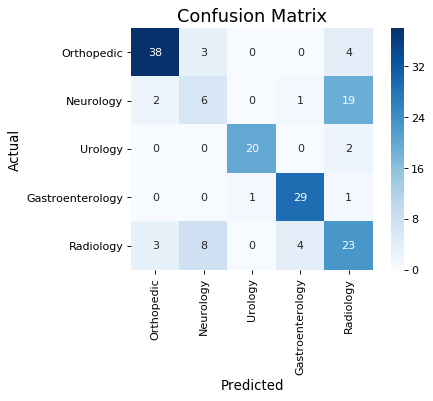

In [18]:
# Plot Multiclass Confusion Matrix
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array, labels = clinical_domain_list)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap='Blues', annot=True, square=True, fmt='d',
       xticklabels=clinical_domain_list,
       yticklabels=clinical_domain_list)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)

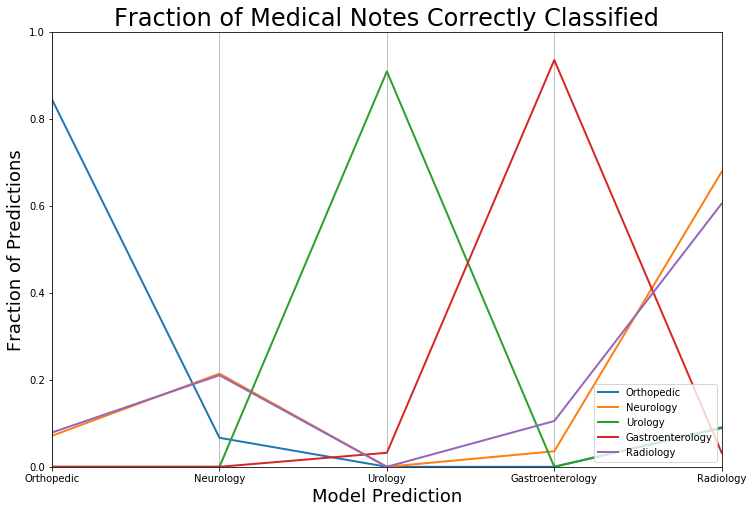

In [20]:
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(5):
    ax.plot(clinical_domain_list, confusion_normalized_array[i], label=clinical_domain_list[i], lw=2)
ax.set_xlabel('Model Prediction', fontsize=18)
ax.set_xlim(left = 0, right = 4)
ax.set_xticks(clinical_domain_list)
ax.set_ylim(bottom = 0, top = 1)
ax.set_ylabel('Fraction of Predictions', fontsize=18)
plt.legend(loc="lower right")
ax.set_title('Fraction of Medical Notes Correctly Classified', fontsize=24)
ax.xaxis.grid(True)
plt.savefig("figures/class-predictions-weighted.png", transparent=False, bbox_inches="tight")

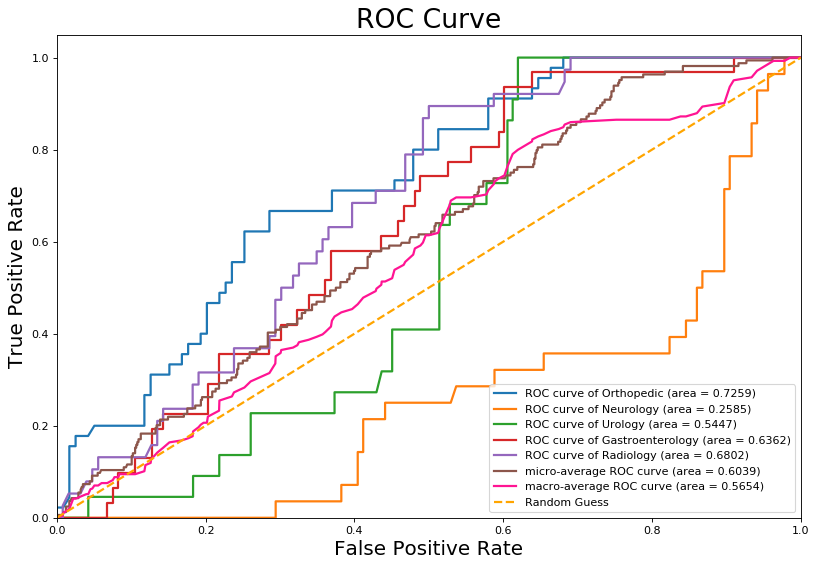

In [21]:
# Compute Multiclass ROC

fpr, tpr, thresholds, roc_auc = compute_multiclass_ROC(target_test_bin_array, features_test_vectorized_proba_array)

# Plot Micro-ROC curve for Weighted Test set
plt.figure(figsize=(12, 8), dpi=80)
for i in range(5):
    plt.plot(1-fpr[i], 1-tpr[i], label='ROC curve of {0} (area = {1:1.4f})'.format(clinical_domain_list[i], 1-roc_auc[i]), lw=2)
plt.plot(1-fpr["micro"], 1-tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["micro"]), lw=2)
plt.plot(1-fpr["macro"], 1-tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=24)
plt.legend(loc="lower right")
plt.savefig("figures/roc-weighted.png", transparent=False, bbox_inches="tight")

# Logistic Regression on Text and Categorical Features

In [ ]:
# Build the pipeline

count = Pipeline([('selector', TextSelector(key='note_text')),
    ('count_vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,3)))])
tfidf = Pipeline([('selector', TextSelector(key='note_text')),
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,3)))])

text_length = Pipeline([('selector', NumberSelector(key='text_length')),
    ('scaler', StandardScaler())])
section_headers_count = Pipeline([('selector', NumberSelector(key='section_headers_count')),
    ('scaler', StandardScaler())])

feats = FeatureUnion([('count', count), 
                      ('tfidf', tfidf), 
                      ('text_length', text_length),
                      ('section_headers_count', section_headers_count)])

# Create the pipeline
pipeline = Pipeline([
    ('feats', feats),
    ('logreg_mlt_pipe clf', LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')),
])